# Installs & Imports

In [1]:
!pip install -q pytorch-lightning torchmetrics missingno

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import time
from tqdm import tqdm
import missingno as msno
import os
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader, TensorDataset, random_split, Subset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from torchmetrics import MeanAbsoluteError, MeanSquaredError, MeanAbsolutePercentageError
import warnings
warnings.filterwarnings('ignore')

# Loading Data

In [3]:
# Define data sources
github_folder = 'https://github.com/xai4heat/xai4heat/raw/main/datasets/'
scada_files = [
    'xai4heat_scada_L4.csv',
    'xai4heat_scada_L8.csv',
    'xai4heat_scada_L12.csv',
    'xai4heat_scada_L17.csv',
    'xai4heat_scada_L22.csv'
]
weather_file = 'weather/ni_20_rs.csv'

In [4]:
# Helper functions
def download_csv(url):
    try:
        df = pd.read_csv(url)
        print(f"Loaded data from {url}")
        return df
    except Exception as e:
        print(f"Error loading data from {url}: {e}")
        return pd.DataFrame()

def strip_out_season_data(df):
    seasons = [
        ('2018-11-01 06:00:00', '2019-04-01 23:00:00'),
        ('2019-11-01 06:00:00', '2020-04-01 23:00:00'),
        ('2020-11-01 06:00:00', '2021-04-01 23:00:00'),
        ('2021-11-01 06:00:00', '2022-04-01 23:00:00'),
        ('2022-11-01 06:00:00', '2023-04-01 23:00:00'),
        ('2023-11-01 06:00:00', '2024-04-01 23:00:00')
    ]
    mask = False
    for start, end in seasons:
        mask |= (df.index >= pd.to_datetime(start)) & (df.index < pd.to_datetime(end))
    df_filtered = df[mask]
    return df_filtered

def handle_missing_values(df, columns_to_update):
    df['e'] = df['e'].replace(0, np.nan)
    for column in columns_to_update:
        df.loc[df['e'].isna(), column] = np.nan
    df.interpolate(method='linear', inplace=True)
    return df

def replace_outliers_with_nan(df, columns, z_thresh=5):
    for column in columns:
        mean = df[column].mean()
        std = df[column].std()
        z_scores = (df[column] - mean) / std
        df.loc[np.abs(z_scores) > z_thresh, column] = np.nan
    return df

def interpolate_missing_values(df, columns):
    df[columns] = df[columns].interpolate(method='linear', inplace=False)
    return df

In [5]:
# Load weather data
weather_url = github_folder + weather_file
dfw = download_csv(weather_url)
if not dfw.empty:
    dfw['datetime'] = pd.to_datetime(dfw['datetime'])
    dfw.set_index('datetime', inplace=True)
    dfw = dfw.drop(['name',
                    'precipprob',
                    'preciptype',
                    'icon',
                    'stations'], axis=1, errors='ignore')
else:
    print("Weather data is empty. Exiting.")
    exit()

Loaded data from https://github.com/xai4heat/xai4heat/raw/main/datasets/weather/ni_20_rs.csv


In [6]:
# Load and preprocess SCADA data
all_data = []
columns_to_update = ['t_amb', 't_ref', 't_sup_prim', 't_ret_prim', 't_sup_sec', 't_ret_sec']

for file in scada_files:
    scada_url = github_folder + file
    df = download_csv(scada_url)
    if df.empty:
        print(f"SCADA file {file} is empty. Skipping.")
        continue
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)

    print(f"Processing file: {file}")
    print('Timeline (from/to):', df.index.min(), df.index.max())

    # Remove data outside of the heating season
    df = strip_out_season_data(df)

    # Keep only full-hour data
    df = df[df.index.minute == 0]

    # Insert missing timepoints
    complete_time_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
    df = df.reindex(complete_time_index)

    # Count energy transmission failures
    zero_count = (df['e'] == 0).sum()
    total = len(df)
    print(f'Data transmission failures: {zero_count}/{total}')

    # Handle missing values
    df = handle_missing_values(df, columns_to_update)

    # Replace outliers with NaN
    df = replace_outliers_with_nan(df, ['t_sup_sec', 't_ret_sec', 't_amb'])

    # Interpolate missing values after outlier removal
    df = interpolate_missing_values(df, ['t_sup_sec', 't_ret_sec', 't_amb'])

    # Merge with weather data
    df = pd.merge(df, dfw, left_index=True, right_index=True, how='inner')

    all_data.append(df)

print(f"Total SCADA datasets loaded and merged with weather data: {len(all_data)}")

Loaded data from https://github.com/xai4heat/xai4heat/raw/main/datasets/xai4heat_scada_L4.csv
Processing file: xai4heat_scada_L4.csv
Timeline (from/to): 2019-08-05 13:00:00 2024-04-04 11:52:00
Data transmission failures: 2200/38712
Loaded data from https://github.com/xai4heat/xai4heat/raw/main/datasets/xai4heat_scada_L8.csv
Processing file: xai4heat_scada_L8.csv
Timeline (from/to): 2021-05-25 13:00:00 2024-04-04 11:52:00
Data transmission failures: 13/21168
Loaded data from https://github.com/xai4heat/xai4heat/raw/main/datasets/xai4heat_scada_L12.csv
Processing file: xai4heat_scada_L12.csv
Timeline (from/to): 2021-05-25 13:00:00 2024-04-04 11:52:00
Data transmission failures: 16/21168
Loaded data from https://github.com/xai4heat/xai4heat/raw/main/datasets/xai4heat_scada_L17.csv
Processing file: xai4heat_scada_L17.csv
Timeline (from/to): 2019-08-05 13:00:00 2024-04-04 11:52:00
Data transmission failures: 89/38712
Loaded data from https://github.com/xai4heat/xai4heat/raw/main/datasets/xa

# Preprocessing Data

In [7]:
def create_lagged_features(df, target_column, num_lags=24):
    for lag in range(1, num_lags + 1):
        df[f'{target_column}_lag_{lag}'] = df[target_column].shift(lag)
    return df

def create_future_features(df, target_column, num_lags=24):
    for lag in range(1, num_lags + 1):
        df[f'{target_column}_future_{lag}'] = df[target_column].shift(-lag)
    return df

def add_cyclical_features(df):
    df['hour_sin'] = np.sin(2 * np.pi * df['hour_of_day']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour_of_day']/24)
    df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
    df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
    return df

In [8]:
# Define columns to drop later
dropcolumns = [
    'solarenergy',
    'uvindex',
    'severerisk',
    'visibility',
    'cloudcover',
    'snow',
    'dew',
    'conditions',
    'e',
    'pe'
]

# Columns to remove after feature engineering
rmv_columns = [
    'day_of_week',
    'is_working_day',
    'precip',
    'windgust',
    'windspeed',
    'winddir',
    't_amb',
    't_sup_prim',
    't_ret_prim',
    't_sup_sec',
    't_ret_sec',
    't_ref',
    'month'
]

# Apply feature engineering to each SCADA DataFrame
for i, df in enumerate(all_data):
    # Add temporal features
    df['hour_of_day'] = df.index.hour
    df['month'] = df.index.month
    df['day_of_week'] = df.index.dayofweek
    df['is_working_day'] = df['day_of_week'].apply(lambda x: 1 if x < 5 else 0)

    # Calculate deltae and heating_on
    df['deltae'] = (df['e'] - df['e'].shift(1)) * 1000
    df['heating_on'] = df['deltae'].apply(lambda x: 1 if x != 0 else 0)

    # Create lagged features for deltae
    df = create_lagged_features(df, 'deltae', num_lags=24)

    # Create future features for temperature
    df = create_future_features(df, 'temp', num_lags=24)

    # Add cyclical features
    df = add_cyclical_features(df)

    # Drop specified columns
    df = df.drop(columns=dropcolumns, axis=1, errors='ignore')
    df = df.drop(columns=rmv_columns, axis=1, errors='ignore')

    # Drop any remaining NaNs after feature engineering
    df = df.dropna()

    # Update the list
    all_data[i] = df

print("Feature engineering completed for all SCADA datasets.")

Feature engineering completed for all SCADA datasets.


In [9]:
def prepare_sequences(features, target, scaler, N=24, M=24):
    """
    Prepares input and target sequences for modeling.

    Parameters:
        features (pd.DataFrame): Feature DataFrame.
        target (pd.Series): Target Series.
        scaler (StandardScaler): Fitted scaler for features.
        N (int): Number of past time steps as input.
        M (int): Number of future time steps to predict.

    Returns:
        TensorDataset: Dataset containing input and target tensors.
    """
    # Normalize features
    features_scaled = scaler.transform(features)

    # Convert to tensors
    features_tensor = torch.tensor(features_scaled, dtype=torch.float32)
    target_tensor = torch.tensor(target.values, dtype=torch.float32)

    # Create sequences
    sequences = []
    targets = []
    for i in range(len(features_tensor) - N - M + 1):
        seq_x = features_tensor[i:i+N]
        seq_y = target_tensor[i+N:i+N+M]
        sequences.append(seq_x)
        targets.append(seq_y)

    sequences_tensor = torch.stack(sequences)
    targets_tensor = torch.stack(targets).view(len(targets), M)

    dataset = TensorDataset(sequences_tensor, targets_tensor)
    return dataset

In [10]:
def dataset_split(dataset, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """
    Splits the dataset into training, validation, and testing sets.

    Parameters:
        dataset (TensorDataset): The complete dataset.
        train_ratio (float): Proportion of data to use for training.
        val_ratio (float): Proportion of data to use for validation.
        test_ratio (float): Proportion of data to use for testing.

    Returns:
        TensorDataset, TensorDataset, TensorDataset: Training, validation, and testing datasets.
    """
    assert train_ratio + val_ratio + test_ratio == 1.0, "Ratios must sum to 1.0"
    total_size = len(dataset)
    train_size = int(train_ratio * total_size)
    val_size = int(val_ratio * total_size)
    test_size = total_size - train_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
    return train_dataset, val_dataset, test_dataset

In [11]:
# Select the SCADA data to model (e.g., index 0 if multiple datasets are loaded)
selected_index = 0
data = all_data[selected_index]
print(f"Selected SCADA dataset: {scada_files[selected_index]}")

# Define target and features
target_column = 'deltae'
feature_columns = data.columns.drop([target_column])

# Define features and target
features = data.drop(columns=[target_column])
target = data[target_column]

Selected SCADA dataset: xai4heat_scada_L4.csv


In [12]:
# Define input_dim directly from the features
input_dim = features.shape[1]
print(f"Input dimension (number of features): {input_dim}")

# Choose nhead as a divisor of input_dim
nhead_candidates = [i for i in range(1, input_dim+1) if input_dim % i == 0]
print(f"Possible nhead values: {nhead_candidates}")

# Select nhead (choose the largest feasible number of heads for better parallelism, up to 8)
nhead = max([i for i in nhead_candidates if i <= 8])
print(f"Selected number of attention heads (nhead): {nhead}")

# Initialize and fit the scaler
scaler = StandardScaler()
scaler.fit(features)

Input dimension (number of features): 60
Possible nhead values: [1, 2, 3, 4, 5, 6, 10, 12, 15, 20, 30, 60]
Selected number of attention heads (nhead): 6


StandardScaler()

In [13]:
# Define input sequence length and future prediction length
N = 24  # Number of past time steps as input
M = 24  # Number of future time steps to predict

# Prepare sequences
dataset = prepare_sequences(features, target, scaler, N=N, M=M)
print(f"Total sequences created: {len(dataset)}")

Total sequences created: 38579


In [14]:
# Split into training, validation, and testing datasets
train_dataset, val_dataset, test_dataset = dataset_split(dataset, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Testing samples: {len(test_dataset)}")

Training samples: 27005
Validation samples: 5786
Testing samples: 5788


# Model Training

In [15]:
class TimeSeriesTransformer(pl.LightningModule):
    def __init__(self, input_dim, num_outputs=24, dim_feedforward=512, nhead=5, num_layers=3, dropout=0.1):
        super().__init__()
        self.save_hyperparameters()

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=input_dim,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Output layer to predict M future steps
        self.linear_out = nn.Linear(input_dim, num_outputs)

        # Metrics
        self.train_mae = MeanAbsoluteError()
        self.train_mse = MeanSquaredError()
        self.train_rmse = MeanSquaredError(squared=False)
        self.train_mape = MeanAbsolutePercentageError()

        self.val_mae = MeanAbsoluteError()
        self.val_mse = MeanSquaredError()
        self.val_rmse = MeanSquaredError(squared=False)
        self.val_mape = MeanAbsolutePercentageError()

    def forward(self, src):
        """
        Forward pass of the model.

        Parameters:
            src (torch.Tensor): Input tensor of shape [batch_size, sequence_length, features]

        Returns:
            torch.Tensor: Output tensor of shape [batch_size, num_outputs]
        """
        # Permute to match Transformer input shape [sequence_length, batch_size, features]
        src = src.permute(1, 0, 2)  # [sequence_length, batch_size, features]

        # Pass through Transformer Encoder
        memory = self.transformer_encoder(src)  # [sequence_length, batch_size, features]

        # Aggregate the encoder outputs (e.g., take the mean over the sequence)
        memory = memory.mean(dim=0)  # [batch_size, features]

        # Pass through the output layer
        out = self.linear_out(memory)  # [batch_size, num_outputs]

        return out

    def training_step(self, batch, batch_idx):
        x, y = batch  # x: [batch_size, N, features], y: [batch_size, M]
        y_hat = self.forward(x)  # y_hat: [batch_size, M]

        loss = nn.MSELoss()(y_hat, y)

        # Log training loss
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)

        # Update metrics
        self.train_mae(y_hat, y)
        self.train_mse(y_hat, y)
        self.train_rmse(y_hat, y)
        self.train_mape(y_hat, y)

        # Log metrics
        self.log('train_mae', self.train_mae, on_step=False, on_epoch=True)
        self.log('train_mse', self.train_mse, on_step=False, on_epoch=True)
        self.log('train_rmse', self.train_rmse, on_step=False, on_epoch=True)
        self.log('train_mape', self.train_mape, on_step=False, on_epoch=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch  # x: [batch_size, N, features], y: [batch_size, M]
        y_hat = self.forward(x)  # y_hat: [batch_size, M]

        loss = nn.MSELoss()(y_hat, y)
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)

        # Update metrics
        self.val_mae(y_hat, y)
        self.val_mse(y_hat, y)
        self.val_rmse(y_hat, y)
        self.val_mape(y_hat, y)

        # Log metrics
        self.log('val_mae', self.val_mae, on_step=False, on_epoch=True)
        self.log('val_mse', self.val_mse, on_step=False, on_epoch=True)
        self.log('val_rmse', self.val_rmse, on_step=False, on_epoch=True)
        self.log('val_mape', self.val_mape, on_step=False, on_epoch=True)

        return {"val_loss": loss}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

In [16]:
def evaluate_model(model, test_loader, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Evaluates the model on the test set and computes MAE, RMSE, and MAPE.

    Parameters:
        model (pl.LightningModule): Trained model.
        test_loader (DataLoader): DataLoader for the test set.
        device (str): Device to perform computations on.

    Returns:
        tuple: MAE, RMSE, and MAPE values.
    """
    # Move the model to the device
    model.to(device)
    model.eval()

    # Initialize metrics
    mae_metric = MeanAbsoluteError().to(device)
    rmse_metric = MeanSquaredError(squared=False).to(device)
    mape_metric = MeanAbsolutePercentageError().to(device)

    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)
            y_hat = model(x)  # [batch_size, M]

            mae_metric.update(y_hat, y)
            rmse_metric.update(y_hat, y)
            mape_metric.update(y_hat, y)

    mae = mae_metric.compute().item()
    rmse = rmse_metric.compute().item()
    mape = mape_metric.compute().item()

    return mae, rmse, mape

In [17]:
def backtest(model_class, dataset, initial_train_size, val_size, n_splits, batch_size=32, max_epochs=5, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Performs rolling window backtesting on the dataset.

    Parameters:
        model_class (class): The PyTorch Lightning model class.
        dataset (TensorDataset): The complete dataset.
        initial_train_size (int): Number of samples in the initial training set.
        val_size (int): Number of samples in each validation set.
        n_splits (int): Number of backtesting splits.
        batch_size (int): Batch size for DataLoaders.
        max_epochs (int): Maximum number of epochs for training.
        device (str): Device to perform computations on.

    Returns:
        dict: Aggregated metrics across all splits.
    """
    metrics = {
        'mae': [],
        'rmse': []
    }

    total_size = len(dataset)
    for split in range(n_splits):
        print(f"--- Split {split + 1}/{n_splits} ---")

        # Define training and validation indices
        train_start = split * val_size
        train_end = initial_train_size + split * val_size
        val_start = train_end
        val_end = val_start + val_size

        if val_end > total_size:
            print("Reached the end of the dataset.")
            break

        train_subset = Subset(dataset, range(train_start, train_end))
        val_subset = Subset(dataset, range(val_start, val_end))

        # Create DataLoaders
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=False)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        # Initialize a fresh model instance
        model = model_class(
            input_dim=input_dim,
            num_outputs=M,
            nhead=nhead,
            dim_feedforward=512,
            num_layers=3,
            dropout=0.1
        )

        # Define callbacks
        checkpoint_callback = pl.callbacks.ModelCheckpoint(
            monitor='val_loss',
            dirpath='checkpoints/',
            filename=f'best-checkpoint-split{split + 1}',
            save_top_k=1,
            mode='min'
        )

        early_stop_callback = pl.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            verbose=False,
            mode='min'
        )

        # Initialize Trainer
        trainer = pl.Trainer(
            max_epochs=max_epochs,
            accelerator='gpu' if device == 'cuda' else 'cpu',
            devices=1 if device == 'cuda' else None,
            callbacks=[checkpoint_callback, early_stop_callback],
            enable_progress_bar=True,
            logger=False
        )

        # Train the model
        trainer.fit(model, train_loader, val_loader)

        # Load the best checkpoint
        best_model_path = checkpoint_callback.best_model_path
        print(f"Best model checkpoint path: {best_model_path}")

        # Load the best model
        best_model = model_class.load_from_checkpoint(best_model_path)
        best_model.to(device)
        best_model.eval()

        # Define test DataLoader as the validation set for this split
        test_loader = val_loader

        # Evaluate the model
        mae, rmse, mape = evaluate_model(best_model, test_loader, device=device)
        print(f"Split {split + 1} - MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.2f}%")

        # Collect metrics
        metrics['mae'].append(mae)
        metrics['rmse'].append(rmse)

    # Aggregate metrics
    aggregated_metrics = {
        'mae_mean': np.mean(metrics['mae']),
        'mae_std': np.std(metrics['mae']),
        'rmse_mean': np.mean(metrics['rmse']),
        'rmse_std': np.std(metrics['rmse'])
    }

    return aggregated_metrics

In [18]:
# Define backtesting parameters
initial_train_size = 20000  # Number of samples in the initial training set
val_size = 5000             # Number of samples in each validation set
n_splits = 3                # Number of backtesting splits

# Execute backtesting
aggregated_metrics = backtest(
    model_class=TimeSeriesTransformer,
    dataset=dataset,
    initial_train_size=initial_train_size,
    val_size=val_size,
    n_splits=n_splits,
    batch_size=32,
    max_epochs=5,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

print("--- Aggregated Backtesting Metrics ---")
print(f"MAE: Mean = {aggregated_metrics['mae_mean']:.4f}, Std = {aggregated_metrics['mae_std']:.4f}")
print(f"RMSE: Mean = {aggregated_metrics['rmse_mean']:.4f}, Std = {aggregated_metrics['rmse_std']:.4f}")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


--- Split 1/3 ---


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                        | Params | Mode 
----------------------------------------------------------------------------
0 | transformer_encoder | TransformerEncoder          | 230 K  | train
1 | linear_out          | Linear                      | 1.5 K  | train
2 | train_mae           | MeanAbsoluteError           | 0      | train
3 | train_mse           | MeanSquaredError            | 0      | train
4 | train_rmse          | MeanSquaredError            | 0      | train
5 | train_mape          | MeanAbsolutePercentageError | 0      | train
6 | val_mae             | MeanAbsoluteError           | 0      | train
7 | val_mse             | MeanSquaredError            | 0      | train
8 | val_rmse            | MeanSquaredError            | 0      | train
9 | val_mape            | MeanAbsolutePercentageError | 0      | train
-----------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Best model checkpoint path: /content/checkpoints/best-checkpoint-split1-v2.ckpt


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                        | Params | Mode 
----------------------------------------------------------------------------
0 | transformer_encoder | TransformerEncoder          | 230 K  | train
1 | linear_out          | Linear                      | 1.5 K  | train
2 | train_mae           | MeanAbsoluteError           | 0      | train
3 | train_mse           | MeanSquaredError            | 0      | train
4 | train_rmse          | MeanSquaredError            | 0      | train
5 | train_mape          | MeanAbsolutePercentageError | 0      | train
6 | val_mae             | MeanAbsoluteError       

Split 1 - MAE: 72.6260, RMSE: 102.1905, MAPE: 1873773.75%
--- Split 2/3 ---


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Best model checkpoint path: /content/checkpoints/best-checkpoint-split2-v1.ckpt


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                        | Params | Mode 
----------------------------------------------------------------------------
0 | transformer_encoder | TransformerEncoder          | 230 K  | train
1 | linear_out          | Linear                      | 1.5 K  | train
2 | train_mae           | MeanAbsoluteError           | 0      | train
3 | train_mse           | MeanSquaredError            | 0      | train
4 | train_rmse          | MeanSquaredError            | 0      | train
5 | train_mape          | MeanAbsolutePercentageError | 0      | train
6 | val_mae             | MeanAbsoluteError       

Split 2 - MAE: 128.2001, RMSE: 173.5071, MAPE: 3790216.75%
--- Split 3/3 ---


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Best model checkpoint path: /content/checkpoints/best-checkpoint-split3-v1.ckpt
Split 3 - MAE: 43.1722, RMSE: 44.0792, MAPE: 41548.61%
--- Aggregated Backtesting Metrics ---
MAE: Mean = 81.3328, Std = 35.2542
RMSE: Mean = 106.5923, Std = 52.9303


# Model Evaluation

In [19]:
def gather_forecasts_actuals(model, loader, M=24, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Gathers all forecasts and actuals from the DataLoader.

    Parameters:
        model (pl.LightningModule): Trained model.
        loader (DataLoader): DataLoader for data.
        M (int): Number of future time steps to predict.
        device (str): Device to perform computations on.

    Returns:
        list, list: Lists of forecasts and actuals for each hour.
    """
    model.to(device)
    model.eval()
    hours_forecasts = [[] for _ in range(M)]
    hours_actuals = [[] for _ in range(M)]

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            y_hat = model(x)  # [batch_size, M]
            y_hat = y_hat.cpu().numpy()
            y = y.cpu().numpy()
            for i in range(M):
                hours_forecasts[i].extend(y_hat[:, i].tolist())
                hours_actuals[i].extend(y[:, i].tolist())

    return hours_forecasts, hours_actuals

In [22]:
def plot_forecasts_vs_actuals(hours_forecasts, hours_actuals, plot_fraction=0.1):
    """
    Plots forecasts vs. actuals for each hour with MAE annotations.

    Parameters:
        hours_forecasts (list): List of forecasts for each hour.
        hours_actuals (list): List of actual values for each hour.
        plot_fraction (float): Fraction of data to plot from the end.

    Returns:
        list: List of MAE values for each hour.
    """
    num_hours = len(hours_forecasts)
    maes = []

    # Determine subplot layout
    num_rows = math.ceil(num_hours / 2)
    fig, axes = plt.subplots(num_rows, 2, figsize=(20, num_rows * 4))
    axes = axes.flatten()

    for i in range(num_hours):
        actuals = np.array(hours_actuals[i])
        forecasts = np.array(hours_forecasts[i])

        # Determine plot range based on plot_fraction
        data_length = len(forecasts)
        plot_points = max(int(data_length * plot_fraction), 100)  # At least 100 points
        start = max(data_length - plot_points, 0)
        end = data_length

        mae = mean_absolute_error(actuals, forecasts)
        maes.append(mae)

        ax = axes[i]
        ax.plot(forecasts[start:end], label='Forecasts', color='blue')
        ax.plot(actuals[start:end], label='Actuals', color='orange')
        ax.set_xlabel('Timepoint')
        ax.set_ylabel('deltae')
        ax.set_title(f'Hour {i} - MAE: {mae:.2f}')
        ax.legend()
        ax.grid(True)

    # Remove any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

    return maes

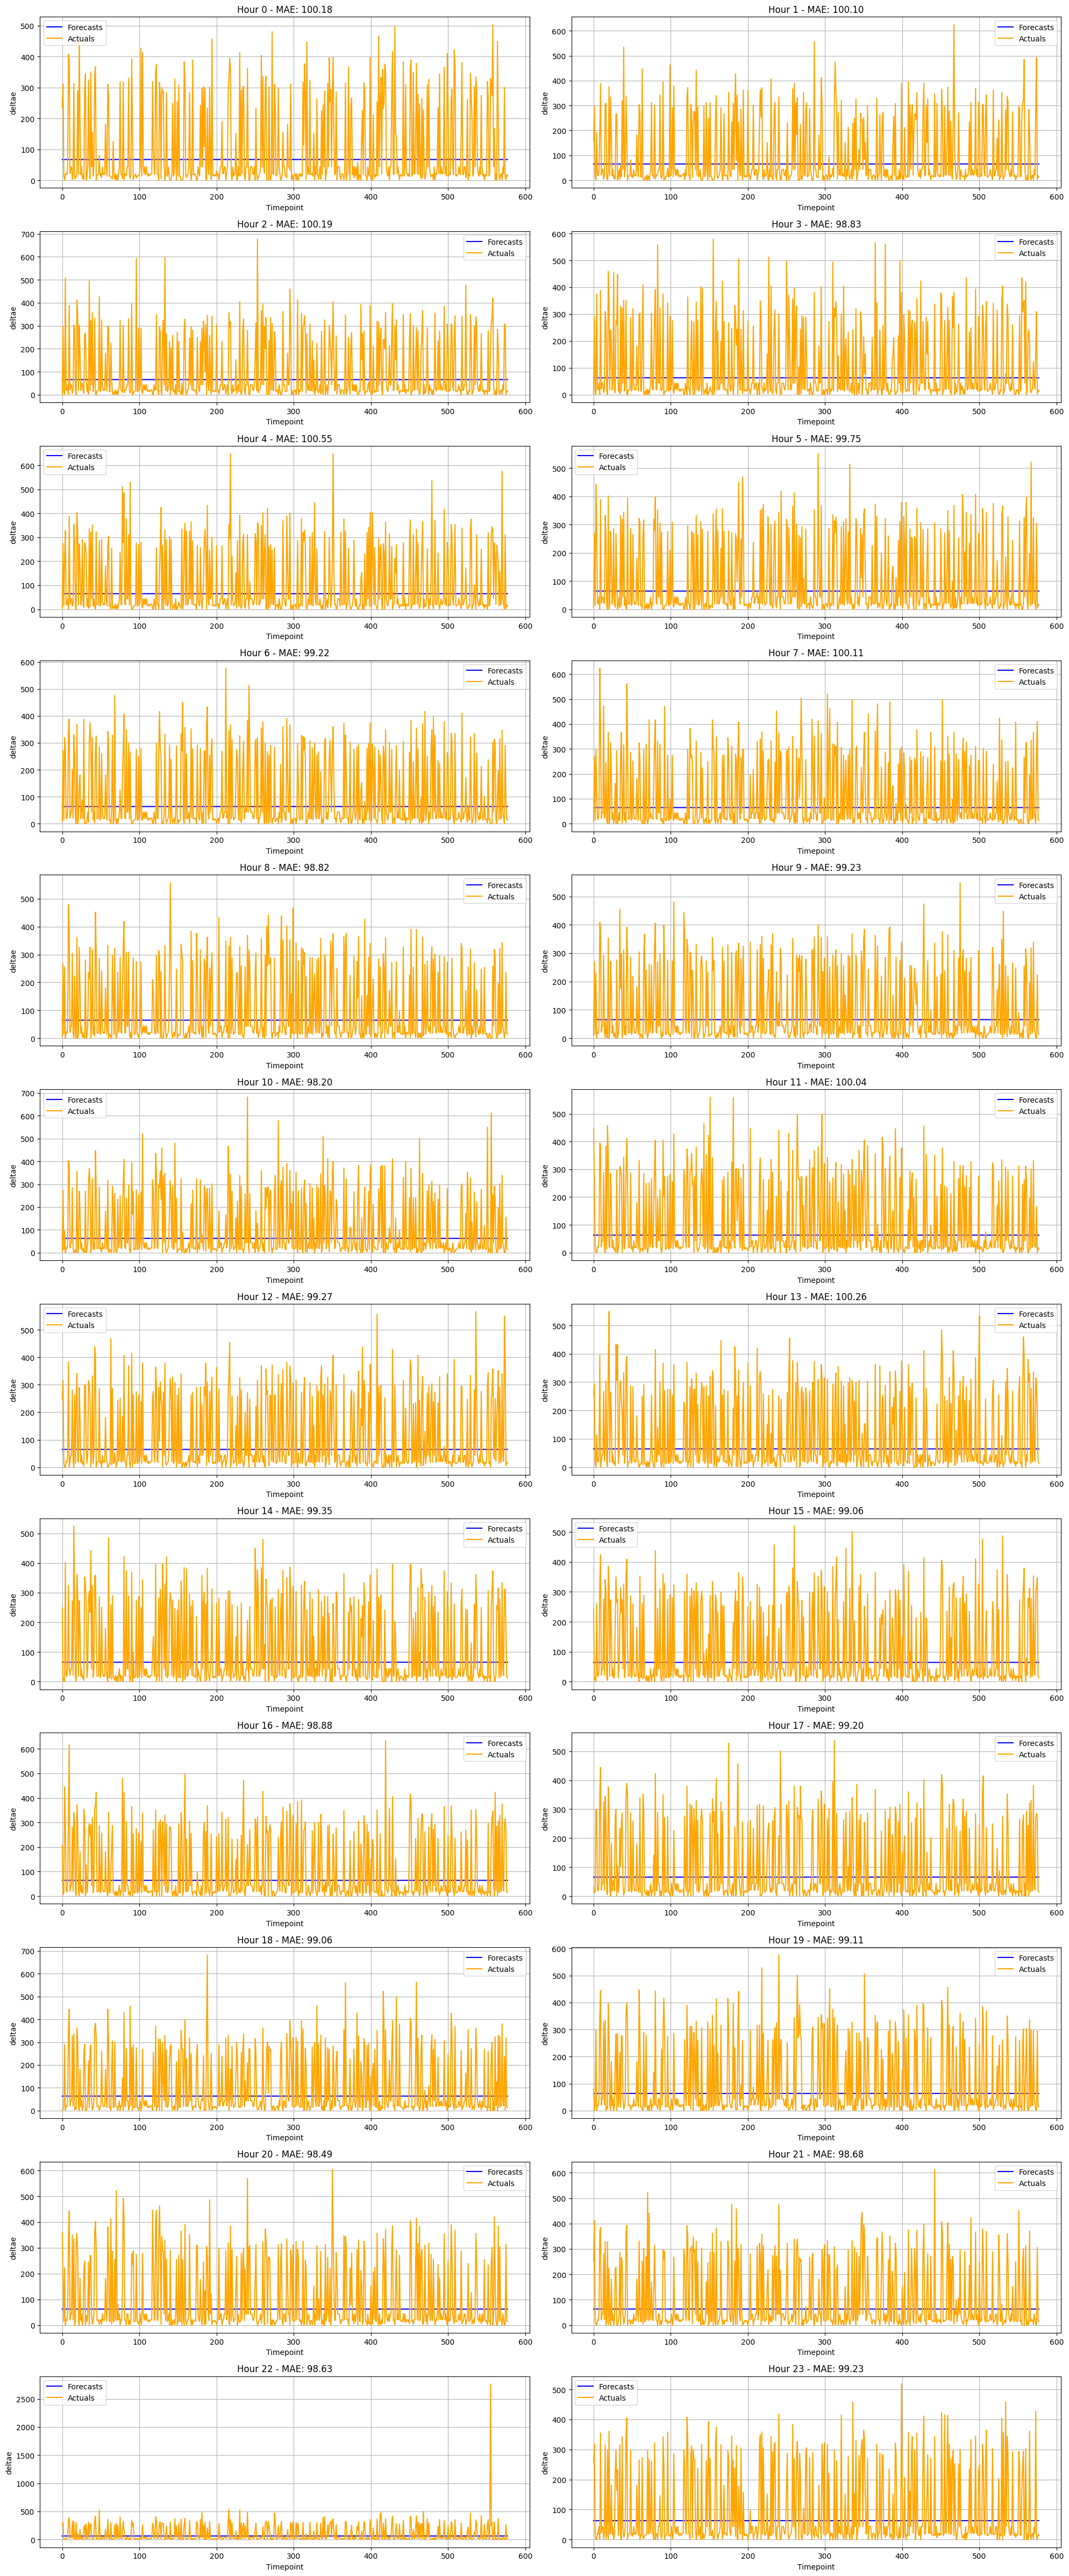

Standard Deviation of MAEs: 0.6319
Summary of Aggregated Backtesting Metrics:
MAE: Mean = 81.3328, Std = 35.2542
RMSE: Mean = 106.5923, Std = 52.9303


In [23]:
# Define the path to the last split's best checkpoint
best_model_checkpoint = f"checkpoints/best-checkpoint-split{n_splits}.ckpt"

# Check if the checkpoint exists
if not os.path.exists(best_model_checkpoint):
    print(f"Checkpoint {best_model_checkpoint} does not exist.")
else:
    # Load the best model from the checkpoint
    best_model = TimeSeriesTransformer.load_from_checkpoint(best_model_checkpoint)

    # Gather forecasts and actuals
    hours_forecasts, hours_actuals = gather_forecasts_actuals(
        model=best_model,
        loader=test_loader,
        M=M,
        device='cuda' if torch.cuda.is_available() else 'cpu'
    )

    # Plot forecasts vs. actuals and retrieve MAEs
    maes = plot_forecasts_vs_actuals(hours_forecasts, hours_actuals, plot_fraction=0.1)

    # Calculate and display standard deviation of MAEs
    std_mae = np.std(maes)
    print(f"Standard Deviation of MAEs: {std_mae:.4f}")

    # Summary of evaluation metrics
    print("Summary of Aggregated Backtesting Metrics:")
    print(f"MAE: Mean = {aggregated_metrics['mae_mean']:.4f}, Std = {aggregated_metrics['mae_std']:.4f}")
    print(f"RMSE: Mean = {aggregated_metrics['rmse_mean']:.4f}, Std = {aggregated_metrics['rmse_std']:.4f}")